In [2]:
import pandas as pd

import glob 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import re
import yaml

## Load the simulation files

- First load the csv with all the properties
- Create a dataframe for labels and scores
- Create plots for all the

In [209]:
simulation_table = pd.read_csv('Tests-list-FL r01csv.csv')

In [210]:
simulation_table.head()

,Simuluation #,attack_type,network_type,n_bits,random_clients,n_clients,trained network,Priority,Who in charge,Completed (Running/Yes/No)
0,1,label,NN,100,0.1,10,yes,yes,NaN,NaN
1,2,label,NN,100,0.1,50,yes,yes,NaN,NaN
2,3,label,NN,100,0.2,10,yes,NaN,NaN,NaN
3,4,label,NN,100,0.2,50,yes,NaN,NaN,NaN
4,5,label,NN,100,0.3,10,yes,yes,NaN,NaN


In [211]:
simulation_table.columns

Index(['Simuluation #', 'attack_type', 'network_type', 'n_bits',
       'random_clients', 'n_clients', 'trained network', 'Priority',
       'Who in charge', 'Completed (Running/Yes/No)'],
      dtype='object')

In [214]:
sim_id_label = list(simulation_table[simulation_table.attack_type == 'label']['Simuluation #'].unique())

In [217]:
sim_id_score = list(simulation_table[simulation_table.attack_type == 'score']['Simuluation #'].unique())

In [246]:
directories = glob.glob("*imulation_*")

In [232]:
def load(conf_file):
    with open(conf_file) as f:
        settings = yaml.safe_load(f)
        return settings


In [233]:
def populate_columns(df,n_clients,network_type,random_clients,n_bits,sim_n):
    df['n_clients'] = n_clients
    df['network_type'] = network_type
    df['random_clients'] = random_clients
    df['n_bits'] = n_bits
    df['sim_n'] = sim_n
    return df

In [248]:
def clean_y(x):
    l = [float(e) for e in x.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
    l_np = np.asarray(l)
    return(l_np.argmax())

In [249]:
def generate_dataframe(d,score_file,event_file,sim_type,df_total):
    setup = os.path.join(d,setup_file)
    settings = load(setup)
    n_clients = settings['setup']['n_clients']
    network_type = settings['setup']['network_type']
    random_clients = settings['setup']['random_clients']
    n_bits = settings['setup']['n_bits']
    
    scores = os.path.join(d,score_file)
    events = os.path.join(d,event_file)
    df_scores = pd.read_csv(scores).drop(columns=['Unnamed: 0'])
    df_events = pd.read_csv(events).drop(columns=['Unnamed: 0'])
    print("scores size: {} {}".format(d,df_scores.shape[0]))
    print("events size: {} {}".format(d,df_events.shape[0]))
    if sim_type == 'score':
        df_scores['y_values'] = df_scores['Y'].str[7:-1]
        df_scores = df_scores.astype({'y_values':float})
    
    elif sim_type == 'label':
        df_scores['label'] = df_scores.Y.apply(lambda x:clean_y(x))
    
    df_merged = pd.merge(df_scores,df_events,on='X',how='outer')
    df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n)    
    df_merged.fillna(value={'E':'run'},inplace=True)
    df_merged.fillna(method='ffill')
    print("\t**merged size: {} {}".format(d,df_merged.shape[0]))
    df_total = pd.concat([df_total,df_merged])

    return df_total

In [250]:

df_total_score = pd.DataFrame()

df_total_label = pd.DataFrame()

setup_file = "setup_tests.yaml"
score_file = "scoreS.csv"
label_file = "scoreL.csv"
event_score_file = "eventS.csv"
event_label_file = "eventL.csv"


for d in directories:
    name,sim_n = d.split('_')
    
    if int(sim_n) in sim_id_score:
        print('{} is a score simulation'.format(d))
        df_total_score = generate_dataframe(d,score_file,event_score_file,'score',df_total_score)
    elif int(sim_n) in sim_id_label:
        print('{} is a label simulation'.format(d))
        df_total_label = generate_dataframe(d,label_file,event_label_file,'label',df_total_label)
        
    

Simulation_5 is a label simulation
scores size: Simulation_5 2100
events size: Simulation_5 405
	**merged size: Simulation_5 2405
Simulation_46 is a label simulation
scores size: Simulation_46 430
events size: Simulation_46 45
	**merged size: Simulation_46 465
Simulation_6 is a label simulation
scores size: Simulation_6 900
events size: Simulation_6 405
	**merged size: Simulation_6 1205
Simulation_7 is a label simulation
scores size: Simulation_7 700
events size: Simulation_7 405
	**merged size: Simulation_7 1005
Simulation_48 is a label simulation
scores size: Simulation_48 170
events size: Simulation_48 45
	**merged size: Simulation_48 205
Simulation_2 is a label simulation
scores size: Simulation_2 2100
events size: Simulation_2 405
	**merged size: Simulation_2 2405
Simulation_3 is a label simulation
scores size: Simulation_3 1400
events size: Simulation_3 405
	**merged size: Simulation_3 1705
Simulation_9 is a label simulation
scores size: Simulation_9 300
events size: Simulation_9

In [251]:
df_total_label.shape

(22005, 9)

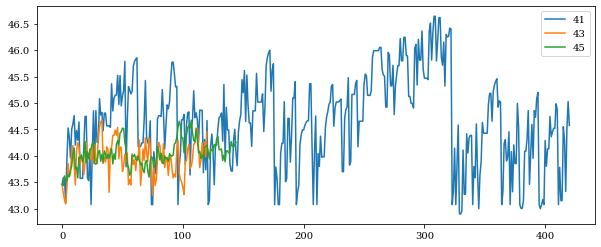

In [252]:
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df_total.groupby(['sim_n']):
    distinct = grp[['X','y_values']].drop_duplicates().dropna().sort_values(by='X')
    ax.plot(distinct['X'], distinct['y_values'], label=key)

ax.legend()
plt.show()

In [58]:
df_total[~df_total['E'].isnull()].head(20)

,X,Y,y_values,E,n_clients,network_type,random_clients,n_bits,sim_n
2,2,tensor(43.5812),43.5812,Receiver added,10,NN,0.1,10,41
71,71,tensor(44.2406),44.2406,Sender added,10,NN,0.1,10,41
72,71,tensor(44.2406),44.2406,Frame start,10,NN,0.1,10,41
107,106,tensor(43.6350),43.6350,Transmissions: 0,10,NN,0.1,10,41
108,106,tensor(43.6350),43.6350,Successful Transmissions: 0,10,NN,0.1,10,41
109,106,tensor(43.6350),43.6350,Errors:1,10,NN,0.1,10,41
110,106,tensor(43.6350),43.6350,Frame start,10,NN,0.1,10,41
145,141,tensor(43.7101),43.7101,Transmissions: 1,10,NN,0.1,10,41
146,141,tensor(43.7101),43.7101,Successful Transmissions: 0,10,NN,0.1,10,41
147,141,tensor(43.7101),43.7101,Errors:2,10,NN,0.1,10,41


In [62]:
df_total_n = df_total.dropna()

In [86]:
filtered = df_total_n[df_total_n['E'].str.startswith('Frame start')]

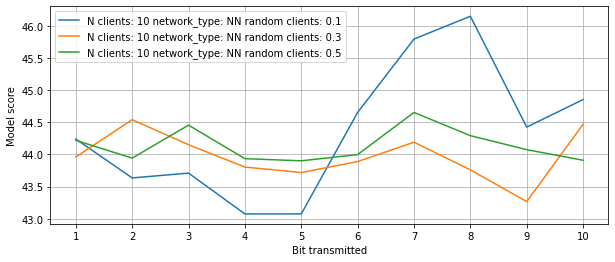

In [109]:
plt.figure(figsize=(10,4))
for key, grp in filtered.groupby(['sim_n']):
    
    label = 'N clients: {}'.format(grp.n_clients.unique()[0])
    label += ' network_type: {}'.format(grp.network_type.unique()[0])
    label += ' random clients: {}'.format(grp.random_clients.unique()[0])
    
    distinct = grp[['y_values']].reset_index()
    plt.plot(distinct.index+1, distinct['y_values'], label=label)
plt.xticks(range(1,11))
plt.legend(loc='best')
plt.xlabel('Bit transmitted')
plt.ylabel('Model score')
plt.grid()
plt.show()

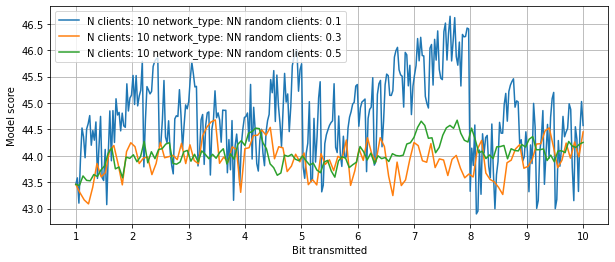

In [194]:
plt.figure(figsize=(10,4))
for key, grp in df_total.groupby(['sim_n']):
    
    label = 'N clients: {}'.format(grp.n_clients.unique()[0])
    label += ' network_type: {}'.format(grp.network_type.unique()[0])
    label += ' random clients: {}'.format(grp.random_clients.unique()[0])
    
    distinct = grp[['y_values']].dropna().drop_duplicates().reset_index()
    distinct['x'] = ((distinct.index)*9 /max(distinct.index))
    plt.plot(distinct.x, distinct['y_values'], label=label)
plt.xticks(range(0,10),range(1,11))
plt.legend(loc='best')
plt.xlabel('Bit transmitted')
plt.ylabel('Model score')
plt.grid()
plt.show()

In [198]:
deltas = grp[grp['E'].str.startswith('Frame start')].reset_index()

In [199]:
deltas.head()

,index,X,Y,y_values,E,n_clients,network_type,random_clients,n_bits,sim_n,success,error
0,26,25,tensor(44.2203),44.2203,Frame start,10,NN,0.5,10,45,0,0
1,41,37,tensor(43.9433),43.9433,Frame start,10,NN,0.5,10,45,0,0
2,56,49,tensor(44.4572),44.4572,Frame start,10,NN,0.5,10,45,0,0
3,71,61,tensor(43.9350),43.9350,Frame start,10,NN,0.5,10,45,0,0
4,86,73,tensor(43.9015),43.9015,Frame start,10,NN,0.5,10,45,0,0


In [203]:
distinct

,index,y_values,x
0,0,43.4574,0.000000
1,1,43.4359,0.063830
2,2,43.6180,0.127660
3,3,43.5337,0.191489
4,4,43.5255,0.255319
...,...,...,...
137,168,44.2703,8.744681
138,169,44.1829,8.808511
139,170,44.1575,8.872340
140,171,44.2186,8.936170


### Plot with events and bits sent

In [13]:
df_total.fillna(value={'E':'run'},inplace=True)

In [14]:
sim_45 = df_total[df_total['sim_n'] == '45'].copy()

In [15]:
sim_45 = sim_45.fillna(method='ffill')

In [21]:
deltas = sim_45[sim_45['E'].str.startswith('Frame start')].copy()

In [22]:
deltas = pd.concat([deltas,sim_45.iloc[-1:,:]])

In [74]:
scores_trans = sim_45[sim_45['X']>=deltas.X.min()][['X','y_values']] 

In [78]:
scores_calib = sim_45[sim_45['X']<=deltas.X.min()][['X','y_values']]

In [24]:
deltas['prev'] = deltas.y_values.shift(1)

In [25]:
import numpy as np 

In [26]:
def get_text(x):
    current = x.y_values
    prev = x.prev
    

In [27]:
deltas['text'] = np.sign(deltas.y_values-deltas.prev)

In [28]:
deltas['position'] = (deltas.X+deltas.X.shift(1))/2

In [40]:
font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 16,
        }


In [182]:
import matplotlib as mpl
mpl.rc('font',family='serif')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


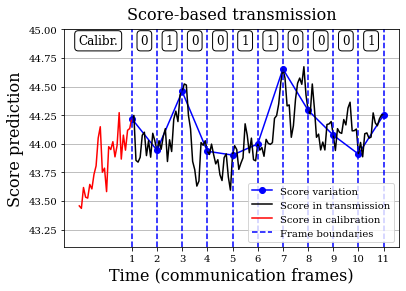

In [188]:

plt.plot(deltas.X,deltas.y_values,'-o',c='b',label='Score variation')


plt.plot(scores_trans.X, scores_trans['y_values'],color='black',label='Score in transmission')
plt.plot(scores_calib.X, scores_calib['y_values'],color='red',label='Score in calibration')

plt.axvline(x=deltas.X.iloc[0],ls='dashed',color='b',label='Frame boundaries')
for i,row in deltas.iloc[1:,:].iterrows():
    plt.axvline(x=row.X,ls='dashed',color='b')

texts = deltas.dropna()

for i,row in texts.iterrows():
    text = '0'
    if row.text == 1:
        text = '1'
    plt.text(row.position,44.9,text,family='serif',fontsize=12,ha="center", va="center",bbox=dict(boxstyle="round",fc='white'))

plt.text(9,44.9,"Calibr.",family='serif',fontsize=12,ha="center", va="center",bbox=dict(boxstyle="round",ec='black',fc='white'))
    
plt.xticks(deltas.X,range(1,12),fontname='serif')

plt.title('Score-based transmission',fontdict=font,pad=10)
plt.xlabel('Time (communication frames)',fontdict=font)
plt.ylabel('Score prediction',fontdict=font)
plt.ylim((43.1,45.0))
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.savefig('score-based-transmission.png', dpi=300)
plt.savefig('score-based-transmission.svg', dpi=300)
plt.savefig('score-based-transmission.eps', dpi=300)
plt.savefig('score-based-transmission.pdf', dpi=300)
plt.show()

### Error rate / Channel capacity plots for label simulations

In [317]:
def clean_bits(x,init_str,n_chars):

    if x is None:
        return 0
    if x.startswith(init_str):
        return int(x[n_chars:])
    return 0
    

In [339]:
df_total_label['success'] = df_total_label.E.apply(lambda x:clean_bits(x,'Succes',26))
df_total_label['error'] = df_total_label.E.apply(lambda x:clean_bits(x,'Error',7))

In [340]:
columns_to_groupby = ['n_clients', 'network_type','random_clients', 'n_bits', 'sim_n']

In [341]:
gb_for_error_rate = df_total_label.groupby(columns_to_groupby,as_index=False).agg({'success': 'max', 'error': 'max'})

In [342]:
gb_for_error_rate['error_rate'] =  gb_for_error_rate['error']/(gb_for_error_rate['success'] + gb_for_error_rate['error']) 

In [343]:
import math

In [344]:
def capacity(x):
    return x*math.log(2*x) + (1-x)*math.log(2*(1-x))  

In [345]:
filtered_10 = gb_for_error_rate[(gb_for_error_rate.n_bits == 100) & (gb_for_error_rate.n_clients == 10)]
filtered_50 = gb_for_error_rate[(gb_for_error_rate.n_bits == 100) & (gb_for_error_rate.n_clients == 50)]

In [429]:
filtered_50.error.sum() + filtered_10.error.sum()

49

In [347]:
filtered_50.dtypes

n_clients           int64
network_type       object
random_clients    float64
n_bits              int64
sim_n              object
success             int64
error               int64
error_rate        float64
dtype: object

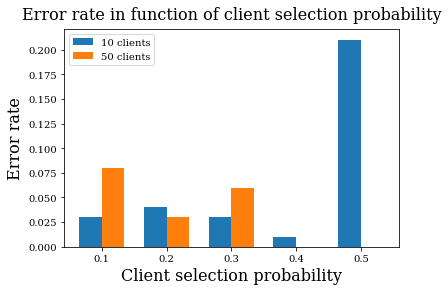

In [349]:
x = np.arange(len(filtered_10.random_clients.unique()))  # the label locations
width = 0.35  # the width of the bars
labels = list(filtered_10.random_clients.unique())
# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

plt.bar(x- width/2,filtered_10.error_rate,width,label='10 clients')
plt.bar(x+ width/2,filtered_50.error_rate,width,label='50 clients')

plt.xticks(x,labels)

plt.title('Error rate in function of client selection probability',fontdict=font,pad=10)
plt.xlabel('Client selection probability',fontdict=font)
plt.ylabel('Error rate',fontdict=font)
plt.legend(loc='upper left')
plt.show()

In [301]:
filtered_50.head()

,n_clients,network_type,random_clients,n_bits,sim_n,success,error,error_rate


## Error rate by probability for score based simulations

In [295]:
df_total_score['success'] = df_total_score.E.apply(lambda x:clean_bits(x,'Succes',26))
df_total_score['error'] = df_total_score.E.apply(lambda x:clean_bits(x,'Error',7))

In [296]:
columns_to_groupby = ['n_clients', 'network_type','random_clients', 'n_bits', 'sim_n']

In [302]:
gb_for_error_rate = df_total_score.groupby(columns_to_groupby,as_index=False).agg({'success': 'max', 'error': 'max'})

In [303]:
gb_for_error_rate['error_rate'] = gb_for_error_rate['error']/(gb_for_error_rate['success'] + gb_for_error_rate['error']) 

In [307]:
gb_for_error_rate.head(10)

,n_clients,network_type,random_clients,n_bits,sim_n,success,error,error_rate
0,10,CNN,0.1,10,51,2,8,0.8
1,10,CNN,0.3,10,53,5,5,0.5
2,10,CNN,0.5,10,55,7,3,0.3
3,10,NN,0.1,10,41,6,4,0.4
4,10,NN,0.3,10,43,5,5,0.5
5,10,NN,0.5,10,45,8,2,0.2


In [310]:
cond_10 = (gb_for_error_rate.network_type == 'NN') & (gb_for_error_rate.n_bits == 10) & (gb_for_error_rate.n_clients == 10)
cond_50 = (gb_for_error_rate.network_type == 'NN') & (gb_for_error_rate.n_bits == 10) & (gb_for_error_rate.n_clients == 50)

In [311]:
filtered_10 = gb_for_error_rate[cond_10]
filtered_50 = gb_for_error_rate[cond_50]

In [314]:
filtered_50.head()

,n_clients,network_type,random_clients,n_bits,sim_n,success,error,error_rate


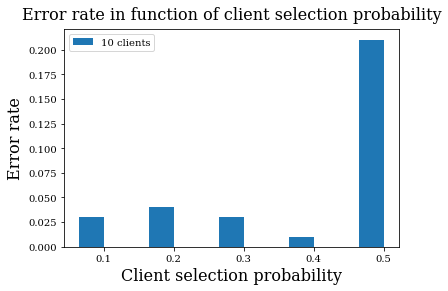

In [338]:
x = np.arange(len(filtered_10.random_clients.unique()))  # the label locations
width = 0.35  # the width of the bars
labels = list(filtered_10.random_clients.unique())
# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

plt.bar(x- width/2,filtered_10.error_rate,width,label='10 clients')
# plt.bar(x+ width/2,filtered_50.error_rate,width,label='50 clients')

plt.xticks(x,labels)

plt.title('Error rate in function of client selection probability',fontdict=font,pad=10)
plt.xlabel('Client selection probability',fontdict=font)
plt.ylabel('Error rate',fontdict=font)
plt.legend(loc='upper left')
plt.show()

## Error rate in time

In [504]:
success = df_total_label[df_total_label.E.str.startswith('Successful Transmissions:')][['X']+columns_to_groupby+['success']]

In [506]:
errors = df_total_label[df_total_label.E.str.startswith('Errors:')][['X']+columns_to_groupby+['error']]

In [507]:
success_errors_time = pd.merge(success,errors,on=['X']+columns_to_groupby,how='inner')

success_errors_time['rate'] = success_errors_time['error']/(success_errors_time['error']+success_errors_time['success'])

In [508]:
success_errors_time.nunique()

X                 631
n_clients           2
network_type        1
random_clients      5
n_bits              2
sim_n              13
success           101
error              22
rate              304
dtype: int64

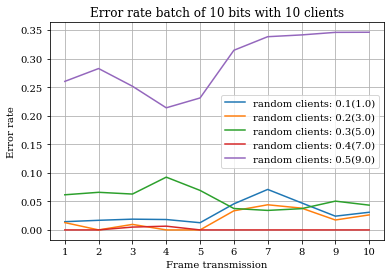

In [509]:
n_clients = 10
n_bits = 100

cond_gb = (success_errors_time['n_bits']==n_bits) & (success_errors_time['n_clients']==n_clients)


filtered_rate = success_errors_time[cond_gb].sort_values(by='sim_n',ascending=False)
filtered_rate = filtered_rate.astype({'sim_n':float})
filtered_rate.sort_values('sim_n')
for key, grp in filtered_rate.groupby(['sim_n']):
    
    label = 'random clients: {}({})'.format(grp.random_clients.iloc[0],grp.sim_n.iloc[0])
    groups = n_bits // 10
    bit_group = grp.groupby(np.arange(len(grp))//groups).agg(lambda x: {'success': x.success.sum(), 
                                                 'error': x.error.sum(),
                                                  'sim_n':x.sim_n.iloc[0],
                                                  'network_type':x.network_type.iloc[0],
                                                   'random_clients':x.random_clients.iloc[0],
                                                   'n_bits':x.n_bits.iloc[0],
                                                   'n_clients':x.n_clients.iloc[0]
                                                  })
    bit_group['rate'] = bit_group.error / (bit_group.success + bit_group.error) 
    plt.plot(range(len(bit_group)), bit_group.rate, label=label)
plt.title('Error rate batch of 10 bits with {} clients'.format(n_clients) )
plt.xticks(range(0,10),range(1,11))
plt.legend(loc='best')
plt.xlabel('Frame transmission')
plt.ylabel('Error rate')
plt.grid()
plt.show()

## Error rate in time for score attack


In [510]:
success = df_total_score[df_total_score.E.str.startswith('Successful Transmissions:')][['X']+columns_to_groupby+['success']]

In [511]:
errors = df_total_score[df_total_score.E.str.startswith('Errors:')][['X']+columns_to_groupby+['error']]

In [512]:
success_errors_time = pd.merge(success,errors,on=['X']+columns_to_groupby,how='inner')

success_errors_time['rate'] = success_errors_time['error']/(success_errors_time['error']+success_errors_time['success'])

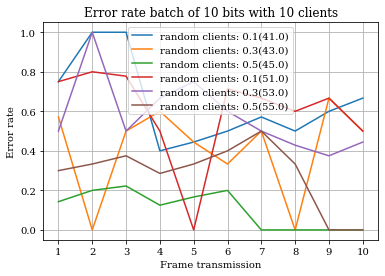

In [516]:
n_clients = 10
n_bits = 10

cond_gb = (success_errors_time['n_bits']==n_bits) & (success_errors_time['n_clients']==n_clients)

filtered_rate = success_errors_time[cond_gb].sort_values(by='sim_n',ascending=False)
filtered_rate = filtered_rate.astype({'sim_n':float})
filtered_rate.sort_values('sim_n')
for key, grp in filtered_rate.groupby(['sim_n']):
    
    label = 'random clients: {}({})'.format(grp.random_clients.iloc[0],grp.sim_n.iloc[0])
    groups = n_bits // 10
    bit_group = grp.groupby(np.arange(len(grp))//groups).agg(lambda x: {'success': x.success.sum(), 
                                                 'error': x.error.sum(),
                                                  'sim_n':x.sim_n.iloc[0],
                                                  'network_type':x.network_type.iloc[0],
                                                   'random_clients':x.random_clients.iloc[0],
                                                   'n_bits':x.n_bits.iloc[0],
                                                   'n_clients':x.n_clients.iloc[0]
                                                  })
    bit_group['rate'] = bit_group.error / (bit_group.success + bit_group.error) 
    plt.plot(range(len(bit_group)), bit_group.rate, label=label)
plt.title('Error rate batch of 10 bits with {} clients'.format(n_clients) )
plt.xticks(range(0,10),range(1,11))
plt.legend(loc='best')
plt.xlabel('Frame transmission')
plt.ylabel('Error rate')
plt.grid()
plt.show()

## count the number of error for 0 / 1

In [350]:
frames = df_total_label[df_total_label['E']=='Frame start'].copy()

In [388]:
frames['prev_label'] = frames.groupby('sim_n')['label'].shift(1)

In [393]:
frames[frames.sim_n == '5'].shape

(100, 12)

In [394]:
def get_bit(x):
    if x.label == x.prev_label:
        return 0
    else:
        return 1

In [395]:
frames['bit_sent'] = frames.apply(lambda x: get_bit(x),axis=1)

In [396]:
frames.head()

,X,Y,label,E,n_clients,network_type,random_clients,n_bits,sim_n,success,error,prev_label,bit_sent
1,44,"tensor([[ -2.5534, -3.8009, -4.3930, 20.628...",8.0,Frame start,10,NN,0.3,100,5,0,0,NaN,1
25,65,"tensor([[ -2.3878, 0.1839, -8.0644, 18.086...",3.0,Frame start,10,NN,0.3,100,5,0,0,8.0,1
49,86,"tensor([[ -2.5296, 0.2453, -7.5033, 17.867...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0
73,107,"tensor([[ -2.5355, 0.9111, -8.4030, 16.320...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0
97,128,"tensor([[ -2.6219, 0.7924, -8.7215, 17.119...",3.0,Frame start,10,NN,0.3,100,5,0,0,3.0,0


In [399]:
_test = pd.merge(df_total_label,frames[['sim_n','X','bit_sent']],on=['sim_n','X'],how='left')

In [418]:
errors = _test[_test['E'].str.contains('Errors:')][['n_clients','network_type','random_clients','n_bits','sim_n','error','bit_sent']]

In [420]:
errors['previous_error'] = errors.groupby('sim_n')['error'].shift(1)

In [425]:
errors[(errors.error - errors.previous_error)>0].bit_sent.value_counts()

0.0    44
1.0     8
Name: bit_sent, dtype: int64

In [400]:
_test.to_csv('test.csv',index=False)

### plot label transmission

In [401]:
settings = load('../label_test/Simulation_46/setup_tests.yaml')

In [402]:
n_clients = settings['setup']['n_clients']
network_type = settings['setup']['network_type']
random_clients = settings['setup']['random_clients']
n_bits = settings['setup']['n_bits']

df_scores = pd.read_csv('../label_test/Simulation_46/scoreL.csv').drop(columns=['Unnamed: 0'])
df_events = pd.read_csv('../label_test/Simulation_46/eventL.csv').drop(columns=['Unnamed: 0'])
print("scores size: {} {}".format(d,df_scores.shape[0]))
print("events size: {} {}".format(d,df_events.shape[0]))
df_merged = pd.merge(df_scores,df_events,on='X',how='outer')

df_merged = populate_columns(df_merged,n_clients,network_type,random_clients,n_bits,sim_n)


scores size: Simulation_55 430
events size: Simulation_55 45


In [403]:
import numpy as np

In [404]:
def clean_y(x):
    print(x)
    l = [float(e) for e in x.replace('tensor([[','').replace(']])','').replace('\n','').split(', ')]
    l_np = np.asarray(l)
    return(l_np.argmax())

In [405]:
df_merged.fillna(value={'E':'run'},inplace=True)

In [406]:
df_merged.fillna(method='ffill',inplace=True)

In [407]:
df_merged = df_merged.sort_values(by='X')

In [408]:
df_merged.head()

,X,Y,E,n_clients,network_type,random_clients,n_bits,sim_n
458,2,"tensor([[-0.2476, -1.0197, -1.4544, 10.7247, -...",Receiver added,10,NN,0.1,10,55
0,88,"tensor([[ -2.6168, -3.7392, -5.0046, 20.414...",Sender added,10,NN,0.1,10,55
1,88,"tensor([[ -2.6168, -3.7392, -5.0046, 20.414...",Frame start,10,NN,0.1,10,55
2,89,"tensor([[ -2.8459, -3.6503, -4.8449, 20.647...",run,10,NN,0.1,10,55
3,90,"tensor([[ -3.2668, -3.2003, -4.6614, 21.257...",run,10,NN,0.1,10,55


In [409]:
df_merged['label'] = df_merged.Y.apply(lambda x:clean_y(x))

tensor([[-0.2476, -1.0197, -1.4544, 10.7247, -7.2667, -9.3813, -4.9705,  2.8151,
         13.8809, -3.2011]])
tensor([[ -2.6168,  -3.7392,  -5.0046,  20.4145, -10.9762,  -1.8441, -14.5304,
         -16.3034,  24.2172,  10.8751]])
tensor([[ -2.6168,  -3.7392,  -5.0046,  20.4145, -10.9762,  -1.8441, -14.5304,
         -16.3034,  24.2172,  10.8751]])
tensor([[ -2.8459,  -3.6503,  -4.8449,  20.6478, -10.7497,  -1.9513, -14.6445,
         -16.2913,  24.1501,  10.6700]])
tensor([[ -3.2668,  -3.2003,  -4.6614,  21.2578, -11.0704,  -1.8599, -14.7144,
         -16.2671,  24.0593,  10.2406]])
tensor([[ -3.1273,  -3.4446,  -4.0442,  21.4171, -11.2315,  -2.1156, -15.0987,
         -16.4170,  24.0455,  10.5139]])
tensor([[ -3.0076,  -3.6575,  -4.4109,  21.0476, -10.8071,  -2.2050, -14.9272,
         -16.3061,  24.1001,  10.6549]])
tensor([[ -3.0872,  -3.5115,  -4.0418,  21.3579, -11.0425,  -2.2399, -15.1053,
         -16.4758,  24.0208,  10.6133]])
tensor([[ -3.1749,  -3.7327,  -4.3673,  21.3080, -

In [410]:
frames = df_merged[df_merged['E']=='Frame start'].copy()

In [411]:
frames['text'] = frames.label == frames.label.shift(1)

In [413]:
frames.shape

(10, 10)

In [166]:
frames['position'] = (frames.X + frames.X.shift(1))/2

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


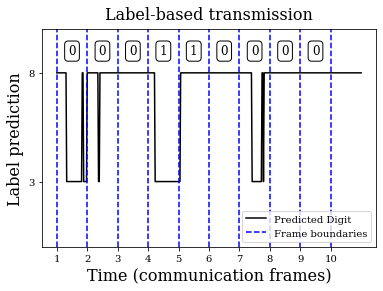

In [192]:

plt.plot(df_merged.iloc[1:,:].X,df_merged.iloc[1:,:]['label'],c='black',label='Predicted Digit')


plt.axvline(x=frames.X.iloc[0],ls='dashed',color='b',label='Frame boundaries')

for i,row in frames.iloc[1:,:].iterrows():
    plt.axvline(x=row.X,ls='dashed',color='b')
    

for i,row in frames.iterrows():
    text = '1'
    if row.text:
        text = '0'
    plt.text(row.position,9,text,family='serif',fontsize=12,ha="center", va="center",bbox=dict(boxstyle="round",fc='white'))


plt.xticks(frames.X,range(1,11),fontname='serif')
plt.yticks([3,8],[3,8],fontname='serif')
plt.ylim((0,10))
plt.title('Label-based transmission',fontdict=font,pad=10)
plt.xlabel('Time (communication frames)',fontdict=font)
plt.ylabel('Label prediction',fontdict=font)
plt.legend(loc ='lower right')
plt.savefig('label-based-transmission.png', dpi=300)
plt.savefig('label-based-transmission.svg', dpi=300)
plt.savefig('label-based-transmission.eps', dpi=300)
plt.savefig('label-based-transmission.pdf', dpi=300)

plt.show()

In [146]:
distinct.head(30)

,X,label
458,2,8
0,88,8
2,89,8
3,90,8
4,91,8
5,92,8
6,93,8
7,94,8
8,95,8
9,96,8


In [125]:
distinct.to_csv('test_label.csv',index=False)

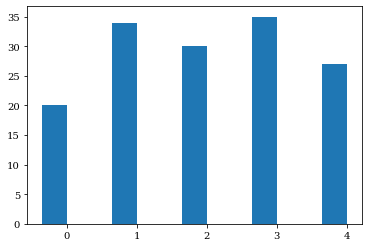

In [279]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 =  plt.bar(x - width/2, men_means, width, label='Men')
